In [199]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

import jax.random as jr
import jax.numpy as jnp
import jax
from dynamax.hidden_markov_model import GaussianHMM, DiagonalGaussianHMM, LinearAutoregressiveHMM

import os
import glob
import h5py

In [106]:
#utils
def load_fmri(data_root, file_pattern):
    data = []
    subjects = []
    folders = sorted([
        f for f in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, f))
    ])
    
    for folder in folders:
        matched_files = glob.glob(os.path.join(data_root, folder, file_pattern))
        if not matched_files:
            print(f"No files found matching {file_pattern} in {folder}")
            continue
            
        for file_path in matched_files:
            try:
                with h5py.File(file_path, 'r') as hdf:
                    data.append(hdf["dataset"][:])
                    subjects.append(folder)
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
                
    return data, subjects

def plot_signals(x, dt=1, n_plot=10, n_parcels=None, title=None, figsize=(10,5)):
    '''
    Plot the trajectory of a signal over time
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    x (ndarray): 2D array (time_steps x n_parcels) representing the trajectory of the signal
    dt (float): Time step used in the simulation
    num_trajectories (int): Number of trajectories to randomly select for plotting
    time_steps (int): Total number of time steps in the simulation
    n_parcels (int): Total number of parcels in the simulation
    --------------------------------------------------------------------------------------------------------
    '''
    time_steps = x.shape[0]
    n_parcels = x.shape[1]

    # Generate the time array
    time = np.arange(0, time_steps * dt, dt)

    # Select random trajectories to plot
    random_indices = np.random.choice(n_parcels, size=n_plot, replace=False)
    selected_trajectories = x[:, random_indices]

    # Create the plot
    plt.figure(figsize=figsize)
    plt.plot(time, selected_trajectories, lw=1.5)
    plt.title(title, fontsize=14)
    plt.xlabel('Time', fontsize=13)
    plt.ylabel('x(t)', fontsize=13)
    plt.yticks([np.round(np.max(selected_trajectories), 0), 0, np.round(np.min(selected_trajectories), 0)])

    # Customize the plot
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()


def compute_pca(signal, n_components=None):
    '''
    Compute the PCA of a given signal
    ---------------------------------------------- PARAMETERS ----------------------------------------------
    - signal (ndarray): The input signal, shape (n_samples, n_features)
    - n_components (int or None): Number of principal components to keep. If None, all components are kept
    --------------------------------------------------------------------------------------------------------
    Returns:
    - pca_components (ndarray): The principal components of the signal
    - explained_variance_ratio (ndarray): The variance explained by each principal component
    '''
    # Initialize PCA
    pca = PCA(n_components=n_components)

    # Fit and transform the signal
    projections = pca.fit_transform(signal)

    # Get explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # eigenvectors
    eigenvectors = pca.components_

    return projections, explained_variance_ratio, eigenvectors

In [107]:
# Load the data
data_root = "/home/zenari/data/fMRI_timeseries_clean_denoised_GSR_parcellated"
file_filter = "task*.h5"
data, subjects = load_fmri(data_root, file_filter)

In [108]:
print('Number of fMRI:', len(subjects))
print('Shape of example fMRI:', data[0].shape)

Number of fMRI: 1630
Shape of example fMRI: (434, 488)


In [109]:
# Filtered list containing only elements with the expected shape
expected_shape = (434, 488)


print('Initial number of fMRI:', len(data))
data_cleaned = [sub for sub in data if sub.shape == expected_shape]
print('Final number of fMRI:', len(data_cleaned))

Initial number of fMRI: 1630
Final number of fMRI: 949


In [110]:
#Subsampling the data
n = 10 #number of fMRI
n_sample = np.random.randint(0, len(data_cleaned), n)

data_sub = [data_cleaned[i] for i in n_sample]

data_sub = np.array(data_sub)

data_sub.shape

(10, 434, 488)

In [111]:
#Zscore the data
data_zsc = np.array([
        (bold_sub - np.mean(bold_sub, axis=1, keepdims=True)) / np.std(bold_sub, axis=1, keepdims=True)
        for bold_sub in data_sub
    ])    

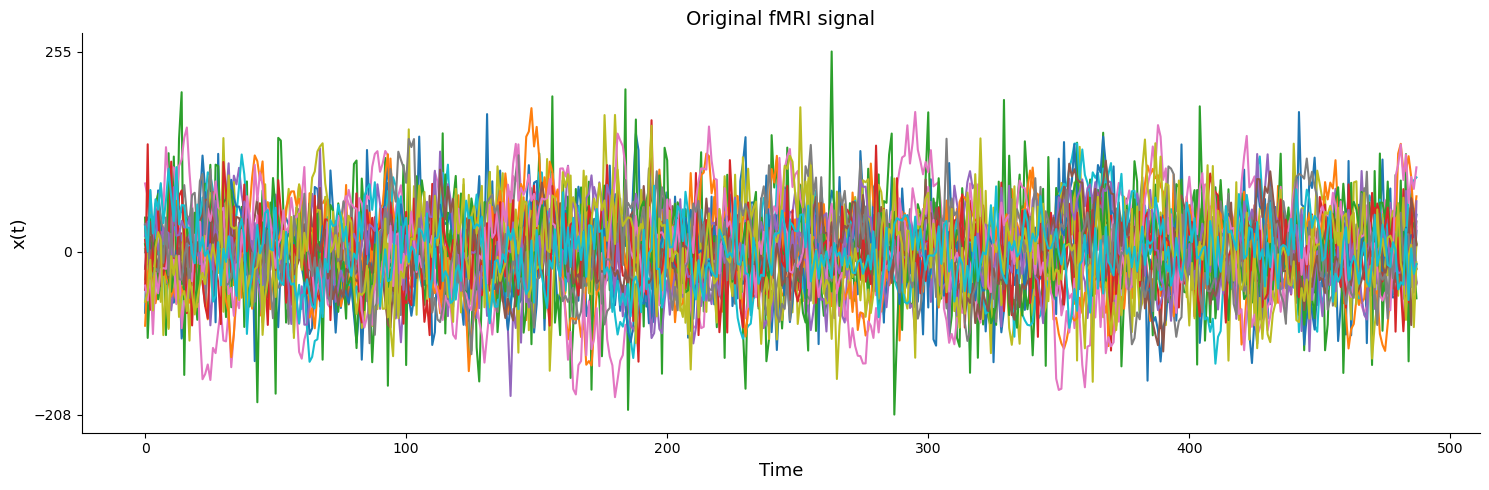

In [112]:
#plotting original sample
k = np.random.randint(0, n)
plot_signals(data_sub[k].T, dt = 1, n_plot=20, n_parcels=data_sub[k].shape[1], title='Original fMRI signal', figsize=(15, 5))

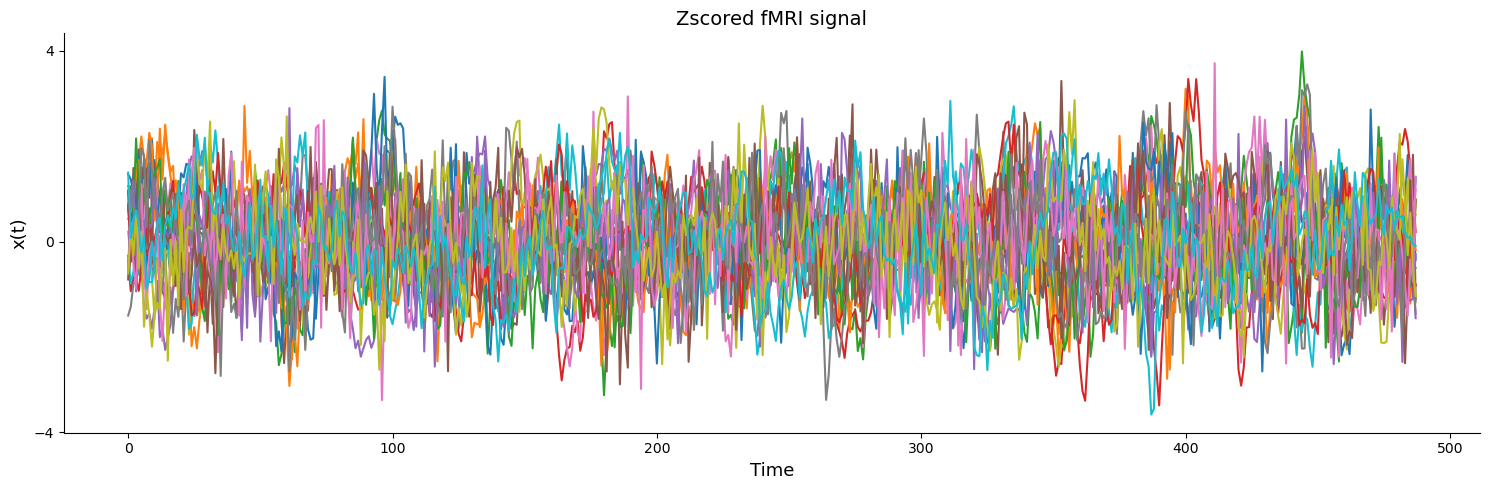

In [113]:
#plotting zscored sample  
plot_signals(data_zsc[k].T, dt = 1, n_plot=20, n_parcels=data_zsc[k].shape[1], title='Zscored fMRI signal', figsize=(15, 5))

In [114]:
print('Shape of the data:', data_zsc.shape)

n_subject = data_zsc.shape[0]
n_parcels = data_zsc.shape[1]
n_time = data_zsc.shape[2]

print('Number of subjects:', n_subject)
print('Number of parcels:', n_parcels)
print('Number of time points:', n_time)

Shape of the data: (10, 434, 488)
Number of subjects: 10
Number of parcels: 434
Number of time points: 488


In [139]:
### concatenating the data
x = data_zsc.transpose(1, 0, 2).reshape(n_parcels, n_time * n_subject)
print('Shape of the concatenated data:', x.shape)

Shape of the concatenated data: (434, 4880)


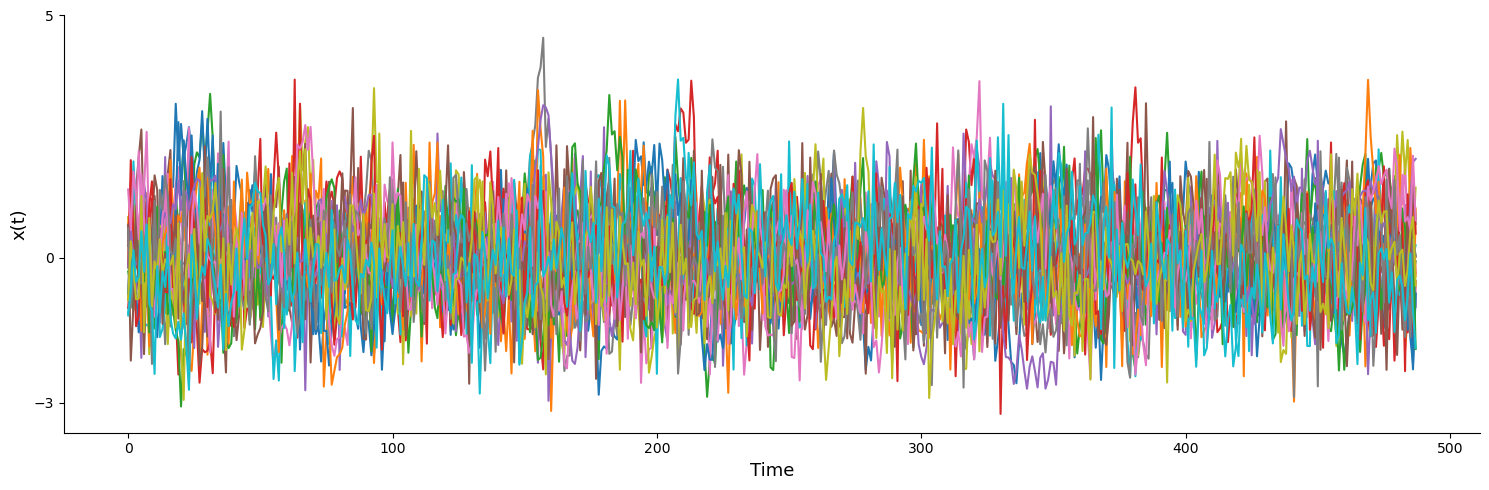

In [140]:
plot_signals(x[:, :488].T, dt = 1, n_plot=20, n_parcels=20, figsize=(15, 5))

In [141]:
#checking for Nan
np.isnan(x).any()

False

### PCA

In [167]:
projections, explained_variance_ratio, eigenvectors = compute_pca(x.T, n_parcels)

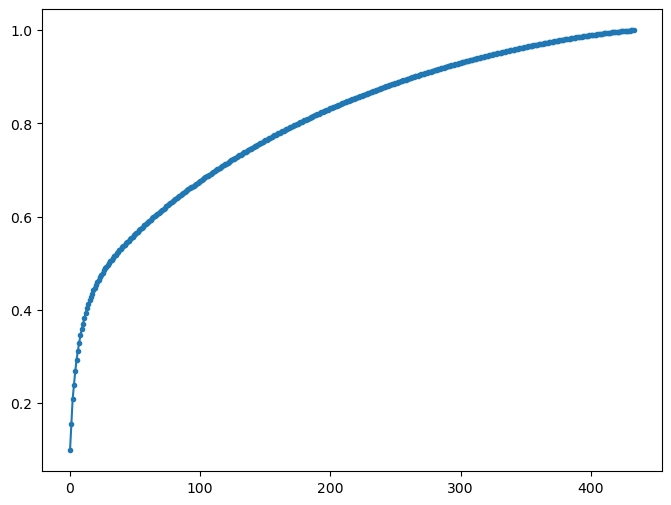

In [150]:
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(explained_variance_ratio), '.-')
plt.show()

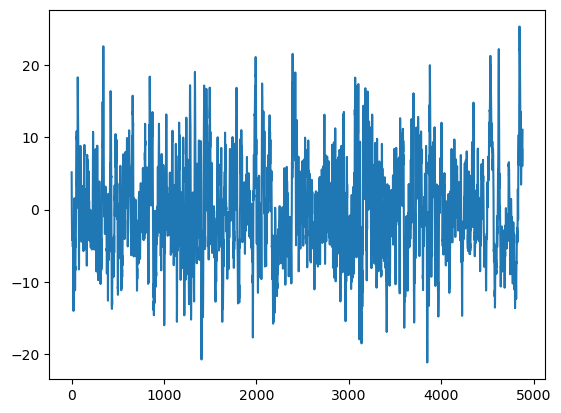

In [180]:
#plotting the time-series of the first pca
plt.plot(projections[:, 0])
plt.show()

## HMM

In [309]:
#hyperparameters
n_components = 5
n_states = 5

emissions = projections[:, :n_components]
emissions_dim = emissions.shape[1]

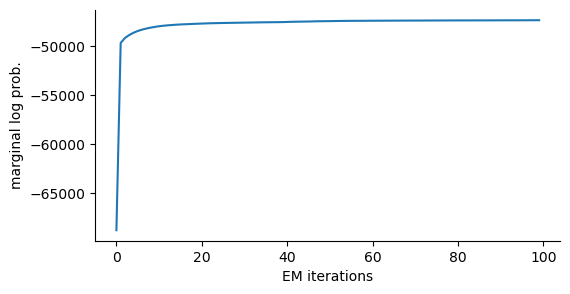

In [310]:
### Create HMM
#hmm = GaussianHMM(n_states, emission_dim)
#hmm = DiagonalGaussianHMM(n_states, emissions_dim)
hmm = LinearAutoregressiveHMM(n_states, emissions_dim, num_lags=10)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)

inputs = hmm.compute_inputs(emissions)

#params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=100, inputs = inputs)


# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()


In [311]:
post = hmm.smoother(params, emissions, inputs= inputs)

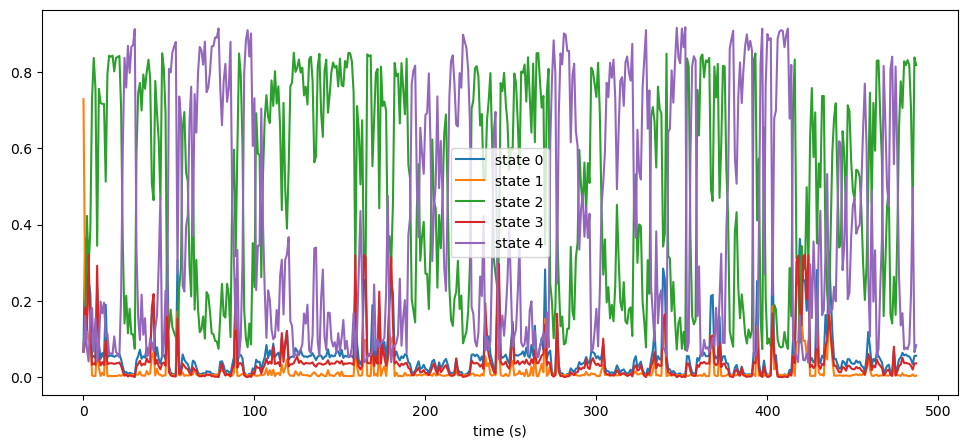

In [312]:
plt.figure(figsize=(26, 5))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(n_time), post.predicted_probs[:n_time, k], label=f'state {k}')
plt.xlabel('time (s)')
plt.legend()

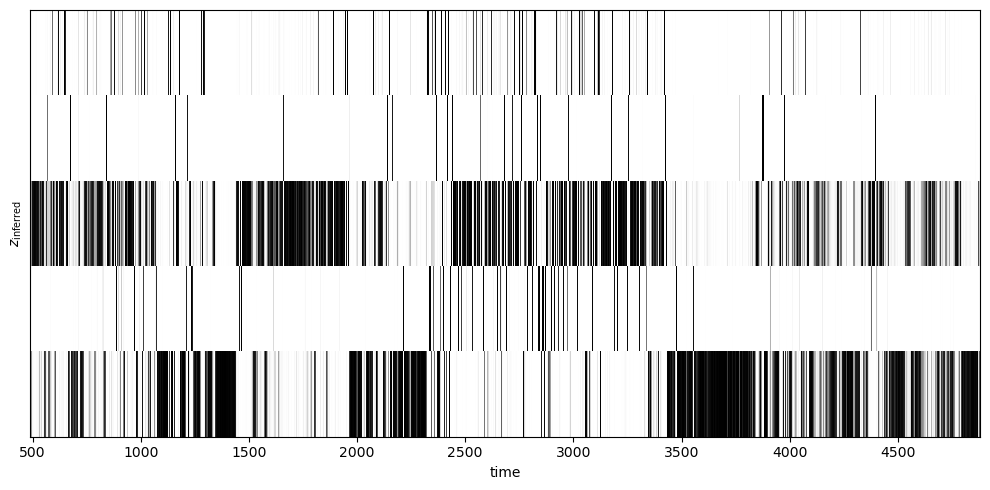

In [317]:
plt.figure(figsize=(10, 5))
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(n_time)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

NameError: name 'true_states' is not defined

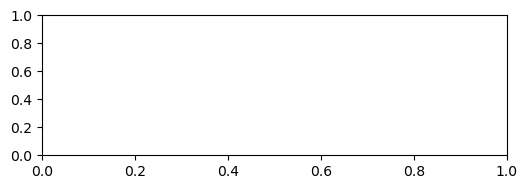

In [314]:
plot_slice = (0, 1000)
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.imshow(true_states[None,num_lags:], aspect="auto", interpolation="none", cmap="viridis", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.title("True and inferred states of the AR-HMM")

plt.subplot(212)
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [287]:
# Plot the true states and the posterior probability 
plot_slice = (0, 1000)
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.imshow(true_states[None,num_lags:], aspect="auto", interpolation="none", cmap="viridis", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.title("True and inferred states of the AR-HMM")

plt.subplot(212)
plt.imshow(post.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

HMMPosterior(marginal_loglik=Array(-88922.59, dtype=float32), filtered_probs=Array([[3.5755089e-05, 3.2936864e-13, 9.9996424e-01],
       [4.3584709e-03, 9.5547408e-01, 4.0167443e-02],
       [1.7970117e-02, 9.6618402e-01, 1.5845861e-02],
       ...,
       [2.9283700e-07, 3.4132551e-11, 9.9999976e-01],
       [2.8801763e-12, 1.4131072e-11, 1.0000000e+00],
       [5.0725387e-08, 2.8234056e-06, 9.9999714e-01]], dtype=float32), predicted_probs=Array([[0.07701176, 0.07692309, 0.84606504],
       [0.04236118, 0.0453685 , 0.91227025],
       [0.13256824, 0.43760693, 0.42982486],
       ...,
       [0.04235998, 0.04536791, 0.9122721 ],
       [0.04235393, 0.04536491, 0.91228116],
       [0.04235386, 0.04536488, 0.9122812 ]], dtype=float32), smoothed_probs=Array([[1.1512112e-04, 3.2796279e-12, 9.9988484e-01],
       [1.7945437e-03, 9.9103755e-01, 7.1679633e-03],
       [2.5951618e-02, 9.3977761e-01, 3.4270808e-02],
       ...,
       [1.9460840e-07, 1.5292727e-11, 9.9999982e-01],
       [1.91

In [279]:
np.isnan(params).any()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

In [266]:
post = hmm.smoother(params, emissions)

TypeError: unsupported operand type(s) for @: 'BatchTracer' and 'NoneType'

In [ ]:
posterior = arhmm.smoother(params, emissions, inputs=inputs)

# Plot the true states and the posterior probability 
plot_slice = (0, 1000)
plt.figure(figsize=(6, 4))
plt.subplot(211)
plt.imshow(true_states[None,num_lags:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.title("True and inferred states of the AR-HMM")

plt.subplot(212)
plt.imshow(posterior.smoothed_probs.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

plt.tight_layout()

In [265]:
TR = 0.8 

# Use fitted model for posterior inference
post = hmm.smoother(params, emissions)


TypeError: unsupported operand type(s) for @: 'BatchTracer' and 'NoneType'

In [261]:
TR = 1

# Use fitted model for posterior inference
post = hmm.smoother(params, emissions)
print(post.smoothed_probs.shape) # (1000, 3)

t_to_show = emissions.shape[1] // 2

plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
for k in range(n_states): plt.plot(np.arange(t_to_show)*TR, post.predicted_probs[:t_to_show, k], label=f'state {k}')
plt.xlabel('time (s)')
plt.legend()

plt.subplot(1,2,2)
plt.bar(x=np.arange(n_states), height=post.predicted_probs.mean(axis=0), alpha=0.5)
#plt.bar(x=np.arange(num_states), height=post.filtered_probs.mean(axis=0), alpha=0.5)

plt.tight_layout()
sns.despine()
plt.show()

TypeError: unsupported operand type(s) for @: 'BatchTracer' and 'NoneType'

In [234]:
type(props[0])

dynamax.hidden_markov_model.models.initial.ParamsStandardHMMInitialState

In [ ]:
### Prepare data for fitting
n_components = 99

n_subj, n_steps, n_parcels = standardized.shape

# Fit PCA
pca = PCA(n_components=n_components)
emissions = pca.fit_transform(standardized.reshape(-1,n_parcels))

# Fit ICA
#ica = FastICA(n_components=n_components)
#emissions = ica.fit_transform(standardized.reshape(-1,n_parcels))

'''
# Create an array of NaNs for the extra timestep
nan_timestep = np.full((n_subj, 1, n_components), np.nan)

# Concatenate the NaNs to the end of each subject's time series
emissions_with_nan = np.concatenate([emissions.reshape(n_subj, n_steps, n_components), nan_timestep], axis=1)

# Flatten back to the original 2D shape with added NaNs
emissions = emissions_with_nan.reshape(-1, n_components)
'''

emission_dim = emissions.shape[-1]
print('data shape:', emissions.shape)

In [ ]:
num_states = 2

### Create HMM
#hmm = GaussianHMM(num_states, emission_dim)
hmm = DiagonalGaussianHMM(num_states, emission_dim)
#hmm = LinearAutoregressiveHMM(num_states, emission_dim, num_lags=1)

### Fit it with EM
params, props = hmm.initialize(emissions=emissions)
params, lls = hmm.fit_em(params, props, emissions, num_iters=10)

# Plot the marginal log probs across EM iterations
plt.figure(figsize=(6,3))
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")
sns.despine()
plt.show()

In [ ]:
data = np.array( [array for array in data if array.shape[1]==493] )   

bold_data_zsc = np.array([
        (bold_sub - np.mean(bold_sub, axis=1, keepdims=True)) / np.std(bold_sub, axis=1, keepdims=True)
        for bold_sub in data
    ])     

concatenated_data = bold_data_zsc.transpose(1, 0, 2)
concatenated_data = concatenated_data.reshape(434, -1)
concatenated_data.shape